### Solving with Euler Equation Iteration

Suppose we have a candidate policy function, $g_n(k,z)$

Our problem is:

$$E_{z′}[f(x,x′,x′′,z,z′) = 0 $$, all $x ∈ X$ and $z ∈ Z$

- Insert $g_n(k,z)$

$$ E_{z′}[f(x,x′,g_n(x′,z′),z,z′) = 0$$, all $x ∈ X$ and $z ∈ Z$

- Use a nonlinear equation solver to find $x′$ , and update to
$g_{n+1(x, z)}$.

- Iterate until

$$||E_{z′}[f(x,g_n(x,z),g_n(g_n(x,z),z′),z,z′)|| < ε$$

### Endogenous grid method

Sometimes, we can isolate $x$ from $E_{z′}[f(x,x′,g_n(x′,z′),z,z′)$. In this case, evaluating $x$ becomes trivial.

The idea of the endogenous grid method is exactly to fix $x'$ and solve for $x$ instead.

Hence, we need to create a grid for $x'$, and then keep iterating on $g(k,k')$.


#### Lets apply it to the Huggett model

The FOC of the model are given by:


In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as sla
from scipy.interpolate import interp1d
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use({'figure.facecolor':'white'})
rc('text', usetex=True)
%config InlineBackend.figure_format = 'retina'

gamma = 2.0
w=5        # wages
beta=1.03**(-1/12)       # discount factor
r=-0.01      # interest rate
phi = -1.0
a_min= -3.0
a_max=18
N = 100
z_vals = [0.5,1]
z_size = 2
Π = np.asarray([[0.4, 0.6], [0.6, 0.4]])  # Markov chain
mu = 0.5
a_vals = np.linspace(a_min,a_max,N)

In [2]:
def time_g(a_vals):
    global gg,gb
    ag1 = a_vals.copy()
    ab1 = a_vals.copy()
    ag = a_vals.copy()
    ab = a_vals.copy()
    metric = 1

    while metric > 1e-6:

        gg = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
        gb = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

        Eg = beta*(1+r)*( Π[0,1]*(a_vals*(1+r)+w-np.maximum(gg(a_vals),phi))**(-gamma)+Π[0,0]*(a_vals*(1+r)+mu*w-np.maximum(gb(a_vals),phi))**(-gamma) )
        Eb = beta*(1+r)*( Π[1,1]*(a_vals*(1+r)+w-np.maximum(gg(a_vals),phi))**(-gamma)+Π[1,0]*(a_vals*(1+r)+mu*w-np.maximum(gb(a_vals),phi))**(-gamma) )

        ag1 = (Eg**(-1/gamma)-w+a_vals)/(1+r)
        ab1 = (Eb**(-1/gamma)-mu*w+a_vals)/(1+r)

        metric = np.array(([abs(ag1-ag),abs(ab1-ab)])).max()

        ag = ag1
        ab = ab1

    return gg, gb

In [3]:
gg, gb = time_g(a_vals)
a1g_star, a1b_star = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)

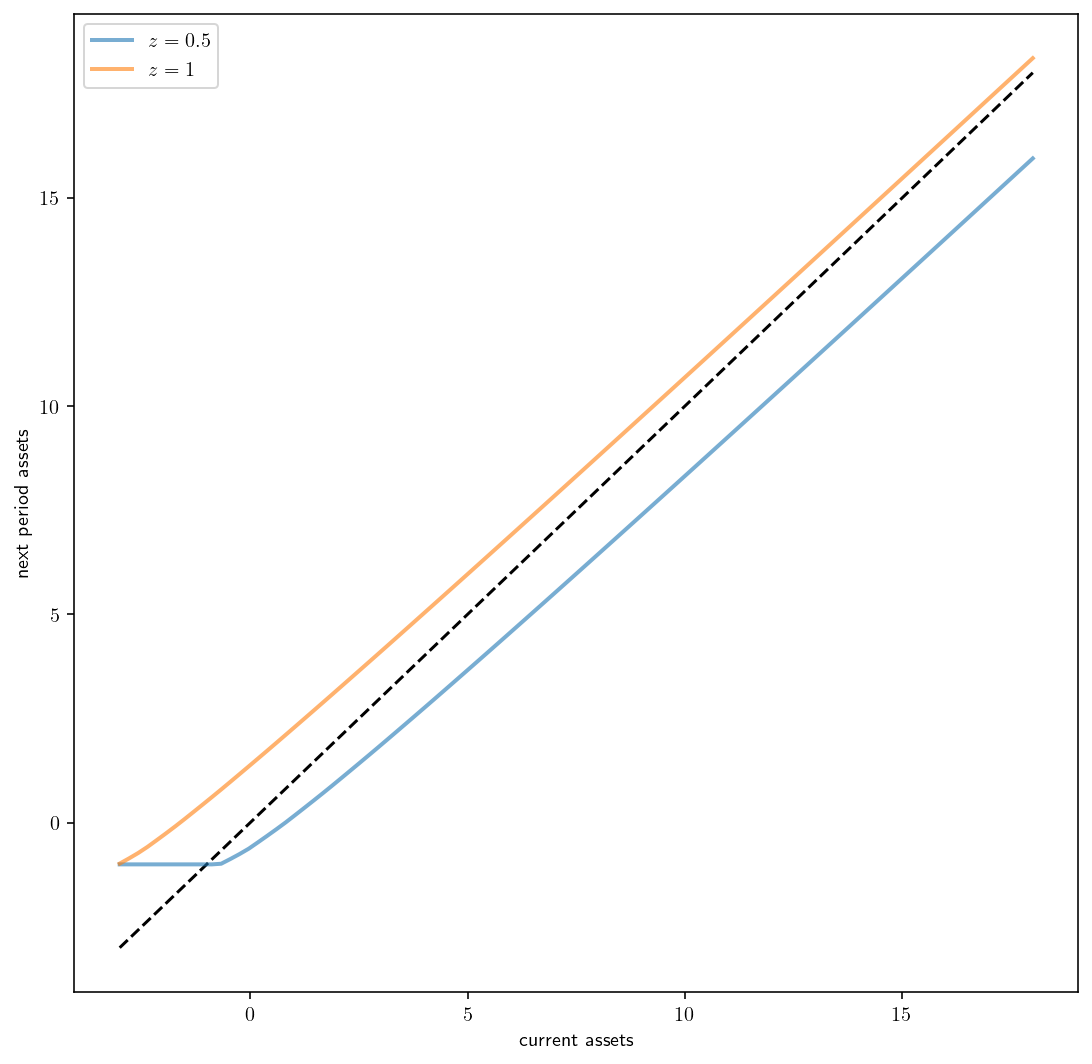

In [4]:
g = [a1b_star, a1g_star]
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')# 45 degrees
for i in range(z_size):
    lb = r'$z = {}$'.format(z_vals[i], '.2f')
    ax.plot(a_vals, g[i], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')
plt.show()

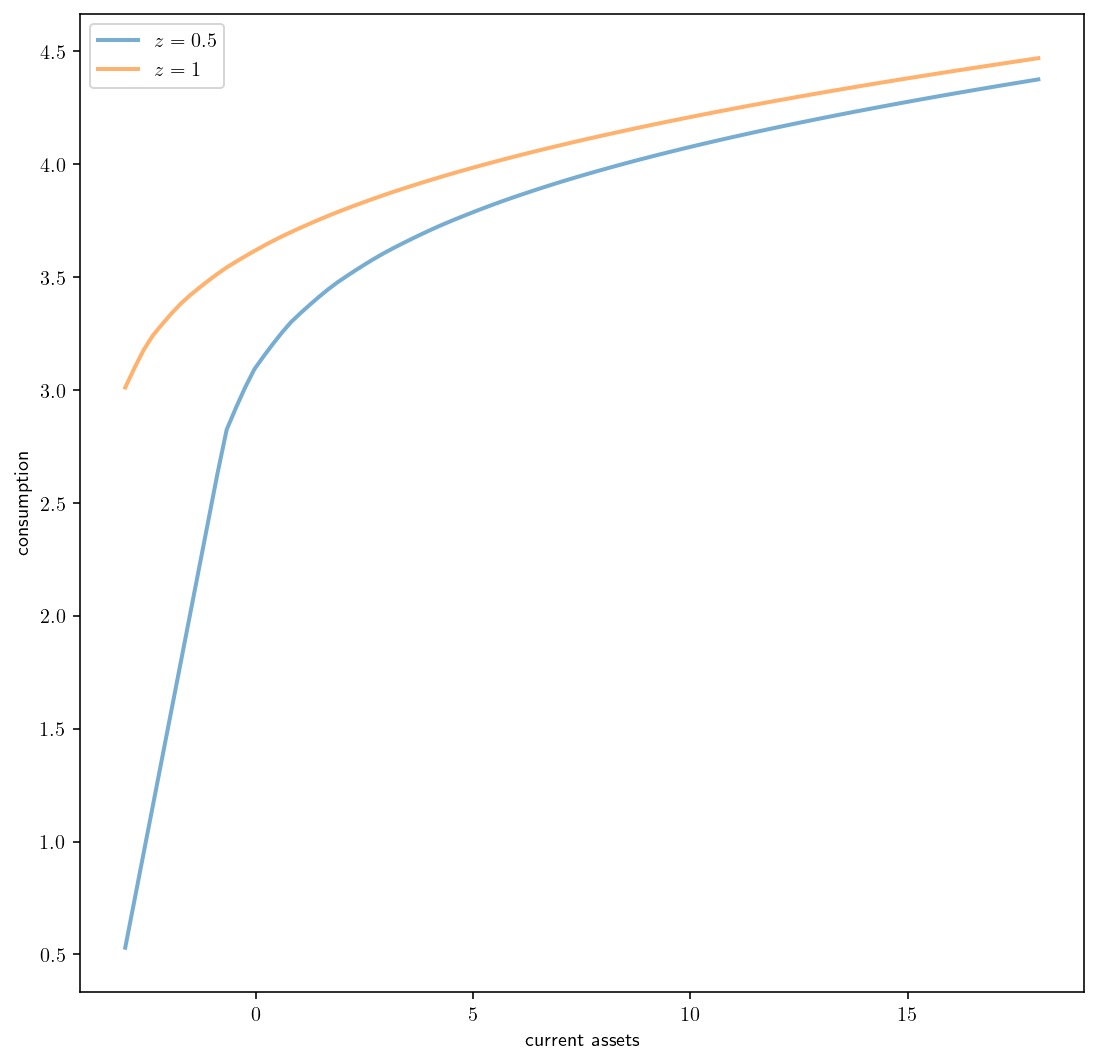

In [5]:
fig, ax = plt.subplots(figsize=(9, 9))
for i in range(z_size):
    lb = r'$z = {}$'.format(z_vals[i], '.2f')
    ax.plot(a_vals, 5 * z_vals[i] + (1 + r) * a_vals - g[i], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('consumption')
ax.legend(loc='upper left')
plt.show()

In [6]:
F = interp1d(a_vals,a_vals, kind = 'next', fill_value=a_vals[-1], bounds_error=False)
a1gd_star = F(np.maximum(gg(a_vals),phi))
a1bd_star = F(np.maximum(gb(a_vals),phi))

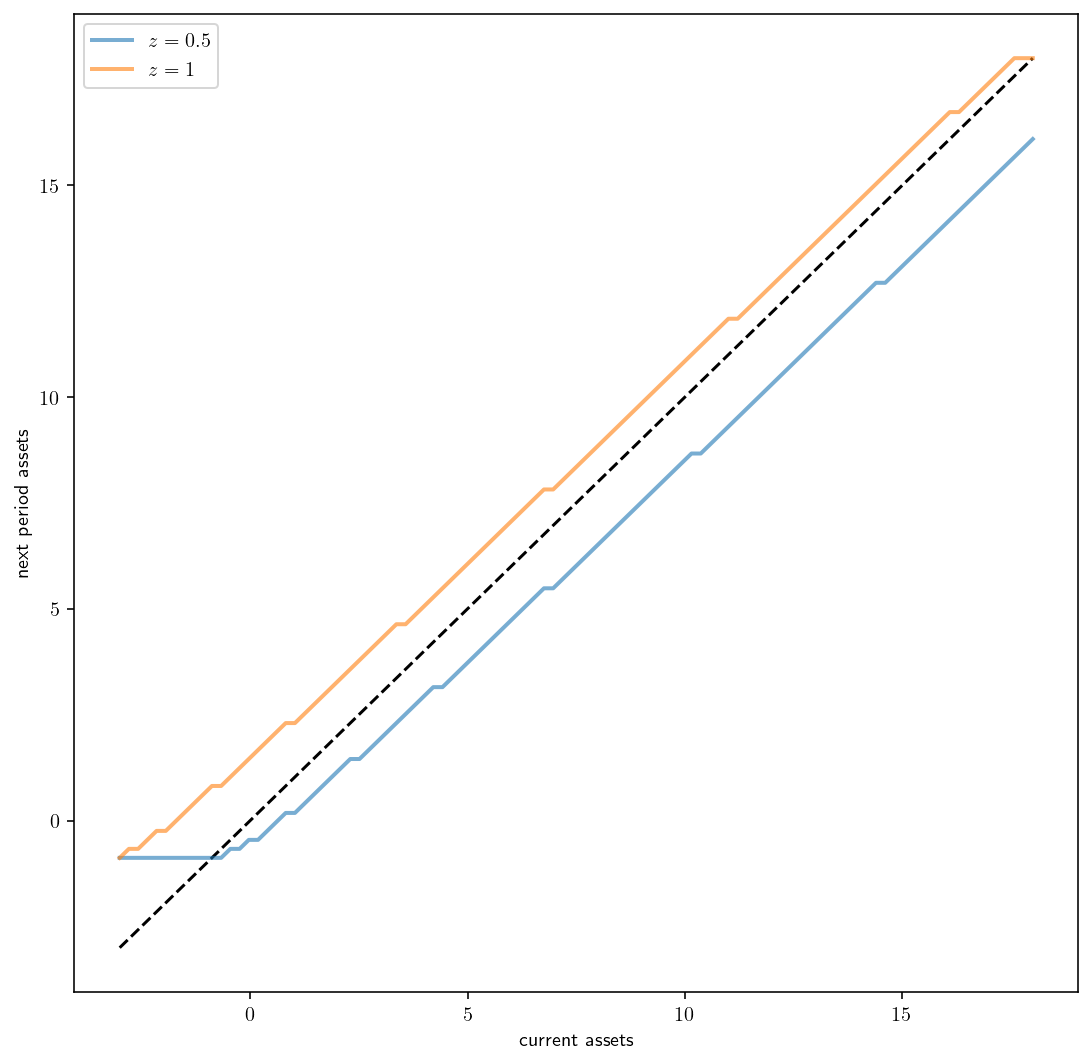

In [7]:
gd = [a1bd_star, a1gd_star]
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')# 45 degrees
for i in range(z_size):
    lb = r'$z = {}$'.format(z_vals[i], '.2f')
    ax.plot(a_vals, gd[i], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')
plt.show()

#### Getting the stationary distribution

In [25]:
Tg = np.zeros([N,N])
Tb = np.zeros([N,N])

for i in range(N):
    ixg = np.where(a_vals==a1gd_star[i])[0][0]
    Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
    if Tg[i,ixg] > 1:
        Tg[i,ixg] = 1.0
    Tg[i,ixg-1] = 1-Tg[i,ixg]

    ixb = np.where(a_vals==a1bd_star[i])[0][0]
    if ixb == 0:
        Tb[i,ixb] = 1
    else:
        Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
        Tb[i,ixb-1] = 1-Tb[i,ixb]
P = Π.copy()

M = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)
M = csr_matrix(M)

M2 = csr_matrix.transpose(M)

D, V = sla.eigs(M2, k=1, sigma = 1.0)
#
V = np.real(V)/sum(np.real(V))
V[np.real(V)<0] = 0
V = np.real(V)/sum(np.real(V))
dist = V[0:N]+V[N:]
mean_a = np.dot(a_vals.T,dist)

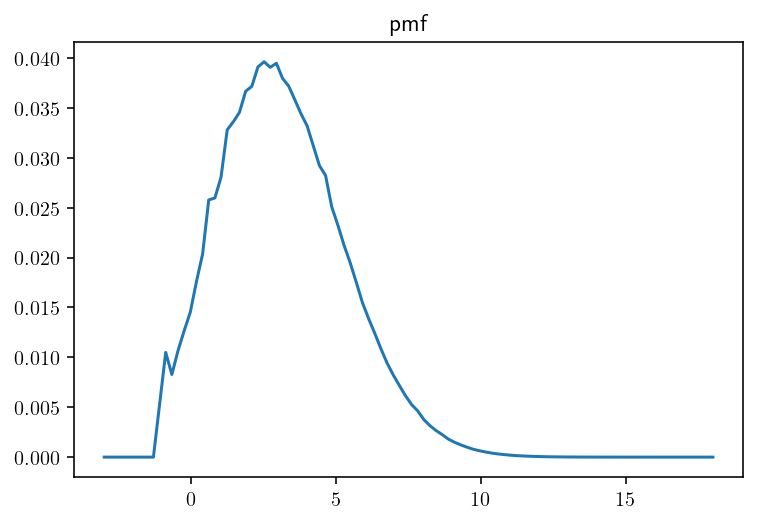

In [26]:
plt.plot(a_vals, dist)
plt.title("pmf")
plt.show()

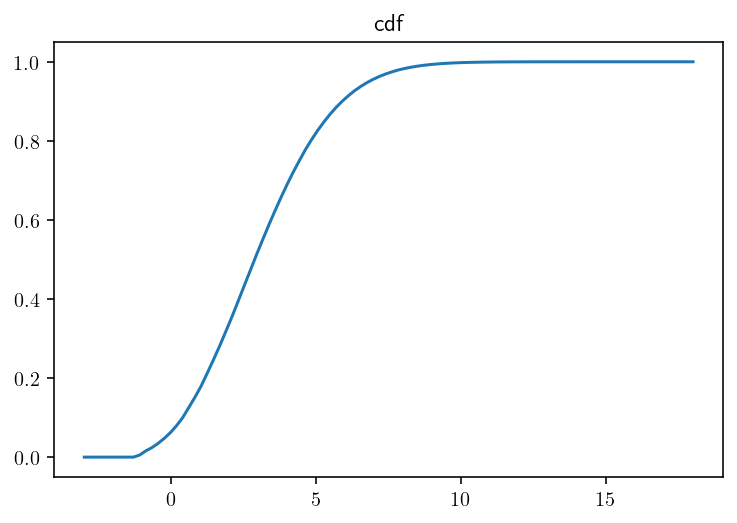

In [27]:
cdf = np.cumsum(dist)
plt.plot(a_vals, cdf)
plt.title("cdf")
plt.show()

#### Monte Carlo

In [928]:
Nagents = 10000
#a0 = np.random.uniform(-3,18,Nagents)
probabilities = np.ones(N)/N
a0 =  np.random.choice(a_vals, Nagents, p=probabilities)
z0 = np.ones(Nagents)
z1 = z0.copy()
a1 = np.zeros(Nagents)
z_values = [0.5,1]
probabilitiesb = Π[0,:]
probabilitiesg = Π[1,:]

for t in range(60):
    for i in range(Nagents):
        if z0[i]==1:
            a1[i] = gg(a0[i])
            z1[i] = np.random.choice(z_values, 1, p=probabilitiesg)
        if z0[i]==0.5:
            a1[i] = gb(a0[i])
            z1[i] = np.random.choice(z_values, 1, p=probabilitiesb)
    a0=a1.copy()
    z0 = z1.copy()

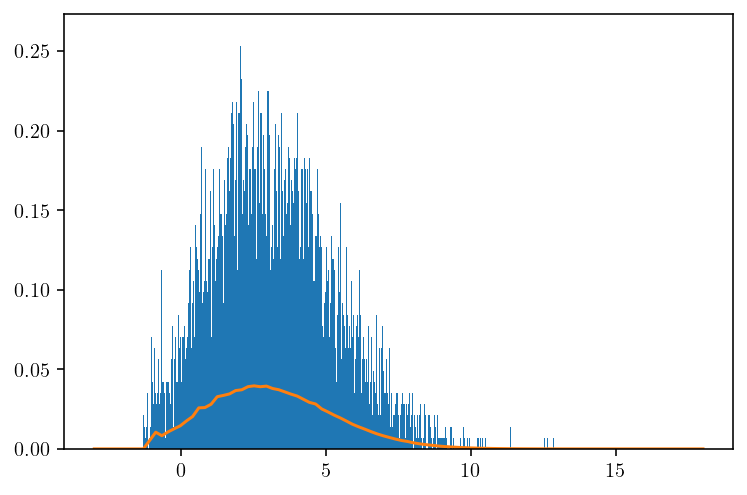

In [930]:
plt.hist(a1, bins = 1000,  density=True )
plt.plot(a_vals, dist)
plt.show()
#print(gd[0][np.where(a0[1000])])

#### Solving for equilibrium

In [1044]:
def time_g(r, a_vals):
    ag1 = a_vals
    ab1 = a_vals
    ag = a_vals
    ab = a_vals
    metric = 1

    while metric > 1e-6:

        gg = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
        gb = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

        Eg = beta*(1+r)*( Π[0,1]*(a_vals*(1+r)+w-np.maximum(gg(a_vals),phi))**(-gamma)+Π[0,0]*(a_vals*(1+r)+mu*w-np.maximum(gb(a_vals),phi))**(-gamma) )
        Eb = beta*(1+r)*( Π[1,1]*(a_vals*(1+r)+w-np.maximum(gg(a_vals),phi))**(-gamma)+Π[1,0]*(a_vals*(1+r)+mu*w-np.maximum(gb(a_vals),phi))**(-gamma) )

        ag1 = (Eg**(-1/gamma)-w+a_vals)/(1+r)
        ab1 = (Eb**(-1/gamma)-mu*w+a_vals)/(1+r)

        metric = np.array(([abs(ag1-ag),abs(ab1-ab)])).max()

        ag = ag1
        ab = ab1

    return gg, gb

def r_to_A(r):
    gg, gb = time_g(r,a_vals)
    a1g_star, a1b_star = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)

    F = interp1d(a_vals,a_vals, kind = 'next', fill_value = a_vals[-1], bounds_error=False)
    a1gd_star = F(np.maximum(gg(a_vals),phi))
    a1bd_star = F(np.maximum(gb(a_vals),phi))

    Tg = np.zeros([N,N])
    Tb = np.zeros([N,N])

    for i in range(N):

        ixg = np.where(a_vals==a1gd_star[i])[0][0]
        Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
        if Tg[i,ixg] > 1:
            Tg[i,ixg] = 1.0
        Tg[i,ixg-1] = 1-Tg[i,ixg]

        ixb = np.where(a_vals==a1bd_star[i])[0][0]
        if ixb == 0:
            Tb[i,ixb] = 1
        else:
            Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
            Tb[i,ixb-1] = 1-Tb[i,ixb]
    P = Π

    M = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)
    M = csr_matrix(M)

    M2 = csr_matrix.transpose(M)

    D, V = sla.eigs(M2, k=1, sigma = 1.0)
    V = np.real(V)/sum(np.real(V))
    V[np.real(V)<0] = 0
    V = np.real(V)/sum(np.real(V))
    dist = V[0:N]+V[N:]
    mean_a = np.dot(a_vals.T,dist)

    return mean_a, dist

In [1046]:
# Lets plot net supply of A for different r
rs = np.linspace(-0.15,0.001, 20)
As = []
dists = []
for r in rs:
    As.append(r_to_A(r)[0])
    dists.append(r_to_A(r)[1])

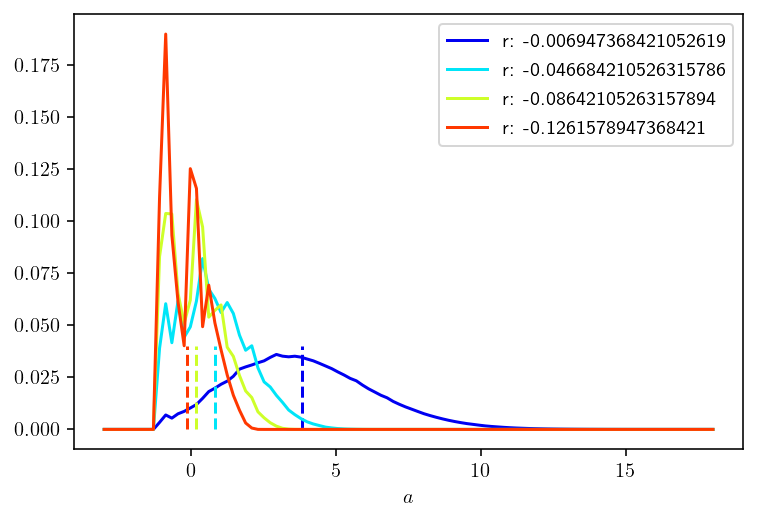

In [1050]:
for i in range(-2,-20, -5):
    plt.plot(a_vals[::1], (dists[i].reshape(N)[::1]),
             color = plt.cm.jet(-i/20),
             label = f'r: {rs[i]}')
    plt.plot(np.ones(len(a_vals))*As[i], np.linspace(0, 0.04, len(a_vals)),
         color=plt.cm.jet(-i/20),
         linestyle = '--')
plt.xlabel(r'$a$')
plt.legend()
plt.show()

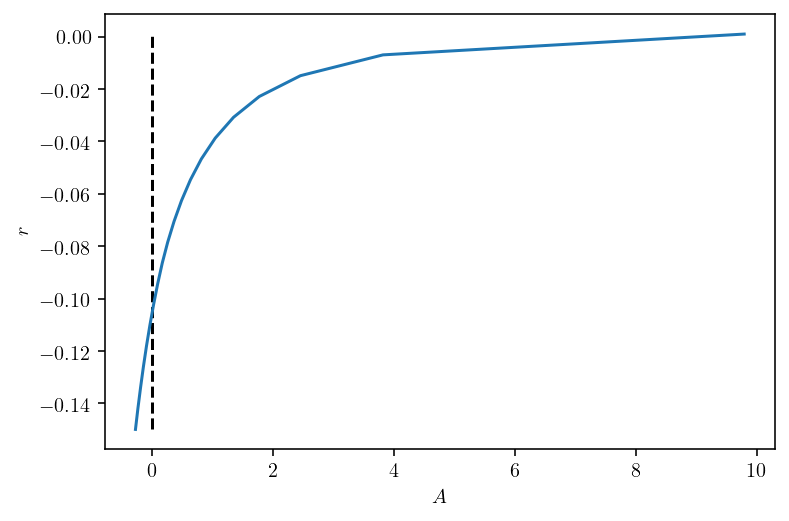

In [1048]:
plt.plot(As, rs)
plt.vlines(0, rs[0], rs[-1], color = 'k', linestyles='--')
plt.ylabel(r'$r$')
plt.xlabel(r'$A$')
plt.show()

In [1049]:
import scipy.optimize as opt
r_sol = opt.bisect(lambda r: r_to_A(r)[0], -0.15, 0.001)
print('The interest rate that clears the bond market is', r_sol)


The interest rate that clears the bond market is -0.10480072497264335
